# Jaundice Detection Project

For previous dataset we will be using skin detections and putting it in dataloader but not in new data set

## Skin Detection

In [1]:
# # our custom transformer to detect only skin
# import matplotlib.pyplot as plt
# import cv2
# import numpy as np

# def custom_skin_detector(img):
#     img = np.array(img)
#     img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#     #skin color range for h in hsv
#     HSV_mask = cv2.inRange(img_HSV[:,:,0], np.array((0)), np.array((17)))
#     HSV_mask = cv2.morphologyEx(HSV_mask,cv2.MORPH_OPEN,np.ones((3,3),np.uint8))

#     #converting from gbr to YCbCr color space
#     img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

#     #putting all values of y to 0
#     img_YCrCb[:,:,0] = 0

#     #skin color range for ycrcb color space 
#     YCrCb_mask = cv2.inRange(img_YCrCb, np.array((0, 135, 85)), np.array((255,180,135))) 
#     YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

#     #global mask made from YCrCb mask and hsv mask
#     global_mask=cv2.bitwise_and(YCrCb_mask,HSV_mask)
#     global_mask=cv2.medianBlur(global_mask,3)
#     global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))
#     global_img = cv2.bitwise_and(img,img,mask=global_mask)
#     global_img = cv2.cvtColor(global_img,cv2.COLOR_BGR2RGB)
#     return global_img

## Getting the data

In [2]:
# from PIL import Image
# class SkinTransform:
#     def __call__(self, image):
#         image = image.convert('RGB')
#         numpy_image = np.array(image)
#         image = numpy_image[:,:,::-1].copy()
#         image = custom_skin_detector(image)
#         image = Image.fromarray(image.astype('uint8'))
#         return image

In [3]:
# import torch
# from torch import nn
# from torch.utils.data import DataLoader, random_split
# from torchvision import datasets, transforms
# import numpy as np

# # transformations
# transform = transforms.Compose([
#     SkinTransform(),
#     transforms.Resize((512,512)),    
#     transforms.ToTensor()
# ])

# # Load the datasets
# dataset = datasets.ImageFolder('./images',transform=transform)


# # combined dataset
# train_size = int(0.8*len(dataset))
# test_size = len(dataset) - train_size

# train_dataset, test_dataset = random_split(dataset, [train_size,test_size],generator=torch.Generator().manual_seed(42))


# # Create the dataloaders
# batch_size = 32
# train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [4]:
# import matplotlib.pyplot as plt
# image,labels = next(iter(train_loader))
# plt.figure()
# plt.imshow(image[0].permute(1,2,0).numpy())
# plt.show()

New Dataset

In [5]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
import numpy as np
import PIL
from PIL import Image, ImageFilter
import os

jaundice_csv = pd.read_csv("./NeoJaundice/chd_jaundice_published_2.csv")
jaundice_csv.head()

,patient_id,image_idx,gender,gestational_age,age(day),weight,blood(mg/dL),Treatment
0,3,0003-1.jpg,F,40,5.2,3280,3.9,0
1,3,0003-2.jpg,F,40,5.2,3280,3.9,0
2,3,0003-3.jpg,F,40,5.2,3280,3.9,0
3,35,0035-1.jpg,M,39,8.7,3760,12.2,0
4,35,0035-2.jpg,M,39,8.7,3760,12.2,0


In [6]:
jaundice_csv.loc[1024]

patient_id                725
image_idx          0725-2.jpg
gender                      M
gestational_age            38
age(day)                  8.0
weight                   3540
blood(mg/dL)              9.8
Treatment                   0
Name: 1024, dtype: object

In [7]:
class CustomDataset(Dataset):
    def __init__(self, csv_path, images_folder, filename_col, label_col, transform = None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform
        self.filename_col = filename_col
        self.label_col = label_col

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df.loc[index][self.filename_col]
        label = self.df.loc[index][self.label_col]
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, label

#### Median Filter

In [8]:
class MedianFilter:
    def __init__(self, kernel_size):
        self.kernel_size = kernel_size

    def __call__(self, img):
        filtered_img = img.filter(ImageFilter.MedianFilter(self.kernel_size))
        return filtered_img

#### Erosion

In [9]:
class Erosion:
    def __init__(self, kernel_size):
        self.kernel_size = kernel_size

    def __call__(self, img):
        # Apply erosion to the image
        eroded_img = img.filter(ImageFilter.MinFilter(size=self.kernel_size))
        return eroded_img

#### Dialation

In [10]:
class Dilation:
    def __init__(self, kernel_size):
        self.kernel_size = kernel_size

    def __call__(self, img):
        # Apply dilation to the image
        dilated_img = img.filter(ImageFilter.MaxFilter(size=self.kernel_size))
        return dilated_img

#### Putting it all together

In [11]:
transform = transforms.Compose([
    transforms.CenterCrop(150),
    transforms.Resize((224,224)),
    # MedianFilter(kernel_size=5),
    Dilation(kernel_size=5),
    Erosion(kernel_size=5),
    transforms.ToTensor(),
])

# importing dataset using new customdataset class
dataset = CustomDataset("./NeoJaundice/chd_jaundice_published_2.csv", "./NeoJaundice/images/", "image_idx", "Treatment",transform=transform)

# splitting size
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size

# split the data
train_dataset, test_dataset = random_split(dataset, [train_size,test_size],generator=torch.Generator().manual_seed(42))

# Create the dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

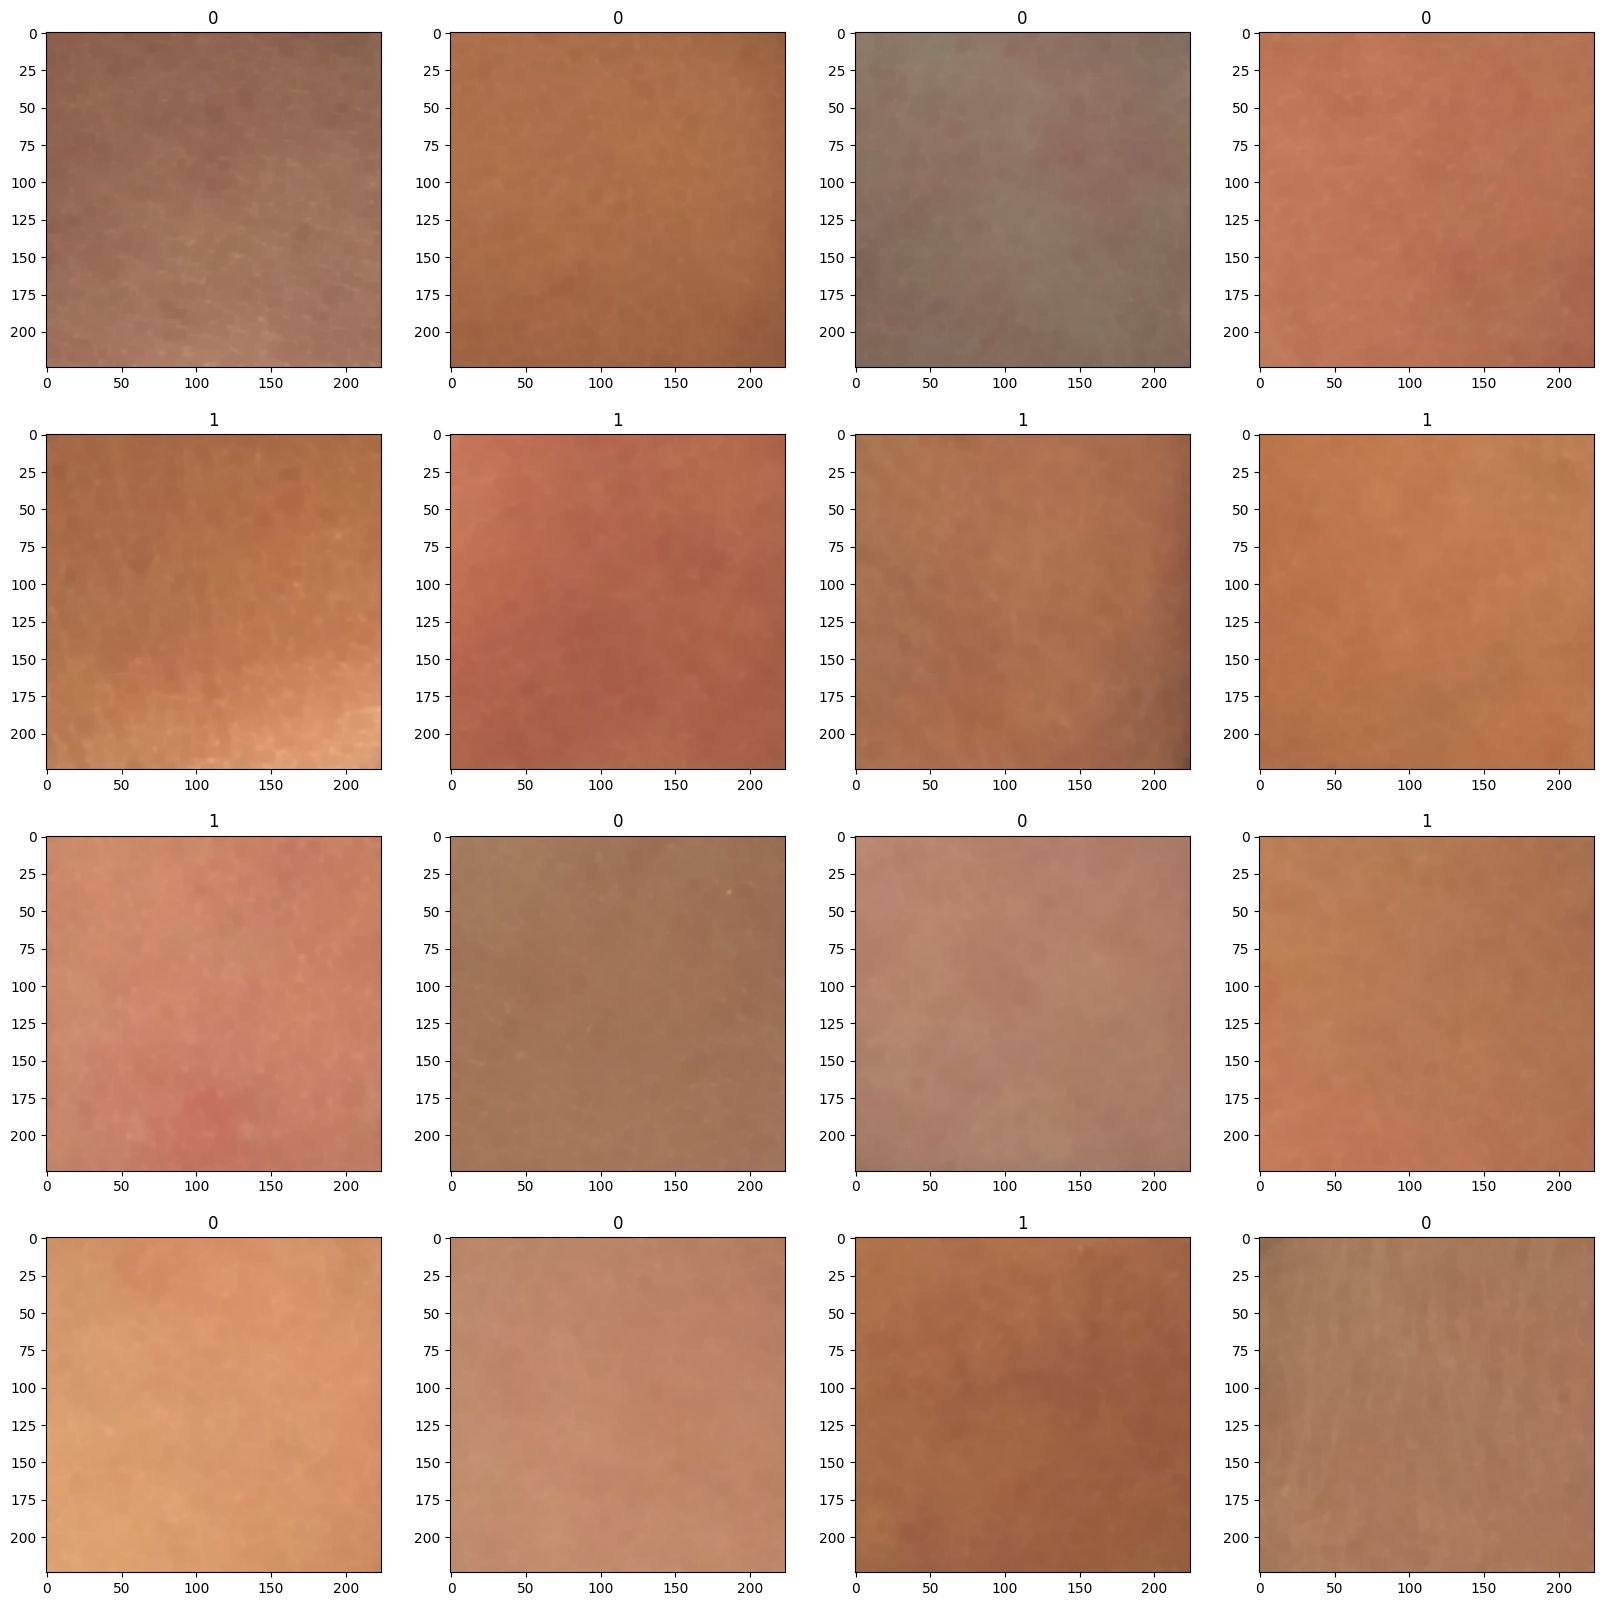

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20,20))
for i in range(16):
    fig.add_subplot(4,4,i+1)
    image,labels = next(iter(train_loader))
    plt.imshow(image[0].permute(1,2,0).numpy())
    plt.title(labels[0].item())
plt.show()


## Models

In [13]:
# # Defining models
# from torchvision import models

# device = "cuda" if torch.cuda.is_available() else "cpu"

# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 1)

#     def forward(self, x):
#         x = self.pool(nn.functional.relu(self.conv1(x)))
#         x = self.pool(nn.functional.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = nn.functional.relu(self.fc1(x))
#         x = nn.functional.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# # device = "cuda" if torch.cuda.is_available() else 'cpu'
# # model = SimpleCNN()

# # # CNN model
# # def CNN():
# #     model = SimpleCNN()
# #     model = model.to(device)

# # # VGG model
# # def VGG():
# #     model = models.vgg16(pretrained= True)
# #     model.eval()
# #     with torch.no_grad():
# #         nn_filters = model.classifier[6].in_features
# #         model.classifier[6] = nn.Linear(nn_filters,1)
# #         model = model.to(device)

# # def resnet():
# #     model = models.resnet34(pretrained = True)
# #     model.eval()

# #     #add a new final layer
# #     with torch.no_grad():
# #         nr_filters = model.fc.in_features  #number of input features of last layer
# #         model.fc = nn.Linear(nr_filters, 1)
# #         model = model.to(device)

# # def alexnet():
# #     model = models.alexnet(pretrained = True)
# #     model.eval()
# #     with torch.no_grad():
# #         nn_filters = model.classifier[6].in_features
# #         model.classifier[6] = nn.Linear(nn_filters,1)
# #         model = model.to(device)

# # def densenet():
# #     model = models.densenet121(pretrained = True)
# #     model.eval()
# #     with torch.no_grad():
# #         nn_filters = model.classifier.in_features
# #         model.classifier = nn.Linear(nn_filters,1)
# #         model = model.to(device)

# # def googlenet():
# #     model = models.googlenet(pretrained = True)
# #     model.eval()
# #     with torch.no_grad():
# #         nn_filters = model.fc.in_features
# #         model.fc = nn.Linear(nn_filters,1)
# #         model = model.to(device)

# # def inceptionv3():
# #     model = models.inception_v3(pretrained = True)
# #     model.eval()
# #     with torch.no_grad():
# #         nn_filters = model.fc.in_features
# #         model.fc = nn.Linear(nn_filters, 1)
# #         model = model.to(device)

# # def mobilenet():
# #     model = models.mobilenet_v2(pretrained = True)
# #     model.eval()
# #     with torch.no_grad():
# #         nn_filters = model.classifier[1].in_features
# #         model.classifier[1] = nn.Linear(nn_filters,1)
# #         model = model.to(device)

# # def squeezenet():
# #     model = models.squeezenet1_1(pretrained = True)
# #     model.eval()
# #     with torch.no_grad():
# #         model.classifier[1] = nn.Conv2d(512,1, kernel_size=(1,1))
# #         model.num_classes = 1
# #         model = model.to(device)

# # model_id = 8

# # if model_id == 0:
# #     CNN()
# # elif model_id == 1:
# #     VGG()
# # elif model_id == 2:
# #     resnet()
# # elif model_id == 3:
# #     alexnet()
# # elif model_id == 4:
# #     densenet()
# # elif model_id == 5:
# #     googlenet()
# # elif model_id == 6:
# #     inceptionv3()
# # elif model_id == 7:
# #     mobilenet()
# # else:
# #     squeezenet()

# # from torchvision import models
# # import torch.nn as nn
# # import torch

# # device = "cuda" if torch.cuda.is_available() else 'cpu'
# # model = models.squeezenet1_1(pretrained=True)

# # model.eval()
# # with torch.no_grad():
# #     model.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1,1))
# #     model.num_classes = 1
# #     model = model.to(device)
    
# model = SimpleCNN()
# model = model.to(device)

In [14]:
# def findConv2dOutShape(hin,win,conv,pool=2):
#     # get conv arguments
#     kernel_size=conv.kernel_size
#     stride=conv.stride
#     padding=conv.padding
#     dilation=conv.dilation

#     hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
#     wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

#     if pool:
#         hout/=pool
#         wout/=pool
#     return int(hout),int(wout)

# import torch.nn as nn
# import torch.nn.functional as F

# # Neural Network
# class Network(nn.Module):
    
#     # Network Initialisation
#     def __init__(self, params):
        
#         super(Network, self).__init__()
    
#         Cin,Hin,Win=params["shape_in"]
#         init_f=params["initial_filters"] 
#         num_fc1=params["num_fc1"]  
#         num_classes=params["num_classes"] 
#         self.dropout_rate=params["dropout_rate"] 
        
#         # Convolution Layers
#         self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
#         h,w=findConv2dOutShape(Hin,Win,self.conv1)
#         self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
#         h,w=findConv2dOutShape(h,w,self.conv2)
#         self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
#         h,w=findConv2dOutShape(h,w,self.conv3)
#         self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
#         h,w=findConv2dOutShape(h,w,self.conv4)
        
#         # compute the flatten size
#         self.num_flatten=h*w*8*init_f
#         self.fc1 = nn.Linear(self.num_flatten, num_fc1)
#         self.fc2 = nn.Linear(num_fc1, num_classes)

#     def forward(self,X):
        
#         # Convolution & Pool Layers
#         X = F.relu(self.conv1(X)); 
#         X = F.max_pool2d(X, 2, 2)
#         X = F.relu(self.conv2(X))
#         X = F.max_pool2d(X, 2, 2)
#         X = F.relu(self.conv3(X))
#         X = F.max_pool2d(X, 2, 2)
#         X = F.relu(self.conv4(X))
#         X = F.max_pool2d(X, 2, 2)

#         X = X.view(-1, self.num_flatten)
        
#         X = F.relu(self.fc1(X))
#         X=F.dropout(X, self.dropout_rate)
#         X = self.fc2(X)
#         return F.log_softmax(X,dim=1)

In [15]:
# # Neural Network Predefined Parameters
# params_model={
#         "shape_in": (3,46,46), 
#         "initial_filters": 8,    
#         "num_fc1": 100,
        # "dropout_rate": 0.25,
#         "num_classes": 2}

# # Create instantiation of Network class
# cnn_model = Network(params_model)

# # define computation hardware approach (GPU/CPU)
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = cnn_model.to(device)

In [16]:
# from torchsummary import summary
# summary(cnn_model, input_size=(3, 46, 46),device=device,batch_size=16)

In [17]:
from models.Alexnet_model import alexnet

device = "cuda" if torch.cuda.is_available() else "cpu"

model = alexnet()
model.eval()
with torch.no_grad():
    nn_filters = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(nn_filters,1)
    model = model.to(device)

## optimizer and loss functions

In [18]:
optimizer_fn = torch.optim.SGD(model.parameters(),lr=0.003,weight_decay=0.000003)
loss_fn = nn.BCEWithLogitsLoss()

## Train and Test loops

In [19]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) *100
    return acc

In [23]:
# Training loop
from torcheval.metrics.aggregation.auc import AUC
from tqdm import tqdm

torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# auc = AUC()
# auc_test = AUC()
for epoch in range(5):
    print(f'!!epoch {epoch+1} is running!!')

    cum_loss = 0
    
    for i,(images, labels) in tqdm(enumerate(train_loader),total = len(train_loader)):
        # Forward pass
        model.train()
        images = images.to(device)
        labels = labels.unsqueeze(1).type(torch.float32)
        labels= labels.to(device)

        output_logits = model(images)
        output_pred = torch.round(torch.sigmoid(output_logits))
        acc = (output_pred == labels).sum().item() / labels.size(0)
        
        # auc.update(output_pred, labels)

        loss = loss_fn(output_logits,labels)
        cum_loss += loss
        
        # Backward pass and optimization
        optimizer_fn.zero_grad()
        loss.backward()
        optimizer_fn.step()
    # print(f'Epoch {epoch+1}, Train Loss: {cum_loss/len(train_loader)}, Accuracy: {acc}, Auc: {auc.compute()}')
    print(f'Epoch {epoch+1}, Train Loss: {cum_loss/len(train_loader)}, Accuracy: {acc}')
    # auc.reset()

    # test loop
    model.eval()
    with torch.no_grad():
        cum_loss = 0
        cum_acc = 0
        for images_test,labels_test in test_loader:
            images_test = images_test.to(device)
            labels_test = labels_test.unsqueeze(1).type(torch.float32)
            labels_test = labels_test.to(device)

            test_logits = model(images_test)
            test_pred = torch.round(torch.sigmoid(test_logits))
            test_loss = loss_fn(test_logits,labels_test)
            # auc_test.update(test_pred, labels_test)
            cum_loss += test_loss
            cum_acc += accuracy_fn(y_true = labels_test, y_pred = test_pred)
        # print(f'Epoch {epoch+1}, Test Loss {cum_loss/len(test_loader)}, accuracy {cum_acc/len(test_loader)}, Auc: {auc_test.compute()}')
        print(f'Epoch {epoch+1}, Test Loss {cum_loss/len(test_loader)}, accuracy {cum_acc/len(test_loader)}')
        # auc_test.reset()

!!epoch 1 is running!!


100%|██████████| 56/56 [02:12<00:00,  2.37s/it]


Epoch 1, Train Loss: 0.6927603483200073, Accuracy: 0.6071428571428571
Epoch 1, Test Loss 0.692102313041687, accuracy 57.286866359447004
!!epoch 2 is running!!


100%|██████████| 56/56 [02:54<00:00,  3.11s/it]


Epoch 2, Train Loss: 0.6912000775337219, Accuracy: 0.5714285714285714
Epoch 2, Test Loss 0.6908366084098816, accuracy 57.27246543778802
!!epoch 3 is running!!


100%|██████████| 56/56 [02:52<00:00,  3.07s/it]


Epoch 3, Train Loss: 0.6897673606872559, Accuracy: 0.6071428571428571
Epoch 3, Test Loss 0.6897318959236145, accuracy 57.25086405529954
!!epoch 4 is running!!


100%|██████████| 56/56 [02:55<00:00,  3.13s/it]


Epoch 4, Train Loss: 0.6885555386543274, Accuracy: 0.5
Epoch 4, Test Loss 0.6887485384941101, accuracy 57.27246543778802
!!epoch 5 is running!!


100%|██████████| 56/56 [02:36<00:00,  2.80s/it]


Epoch 5, Train Loss: 0.6874175667762756, Accuracy: 0.6428571428571429
Epoch 5, Test Loss 0.6878889203071594, accuracy 57.27966589861751


## Accuracy and plotting

In [ ]:
images, label = next(iter(test_loader))

model.eval()
with torch.inference_mode():
    pred = model(images)
label, torch.round(torch.sigmoid(pred)).T

(tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
         1, 0, 1, 1, 0, 0, 0, 1]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


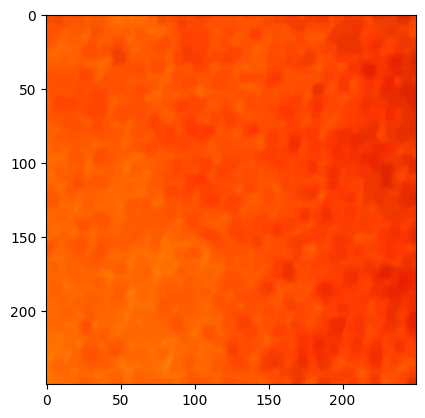

In [ ]:
import matplotlib.pyplot as plt
image,labels = next(iter(train_loader))
plt.figure()
plt.imshow(image[0].permute(1,2,0).numpy())
plt.show()

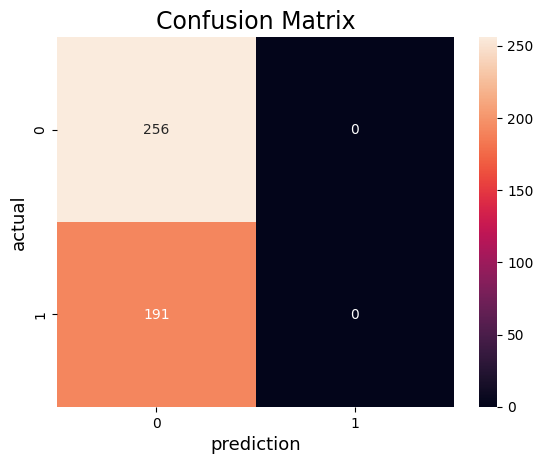

In [ ]:
# Confusion Matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

images,labels = [],[]
for i,(Images,Labels) in enumerate(test_loader):
    images.append(Images)
    labels.append(Labels.detach().numpy())
image_ouput = []
for image in images:
    image_ouput.append(torch.round(torch.sigmoid(model(image))).squeeze().detach().numpy())

cm = confusion_matrix(np.concatenate(labels),np.concatenate(image_ouput))


sns.heatmap(cm,annot=True, fmt='g')
plt.ylabel('actual',fontsize=13)
plt.xlabel('prediction',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [ ]:
image_ouput

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=fl

## Results
### Squeezenet
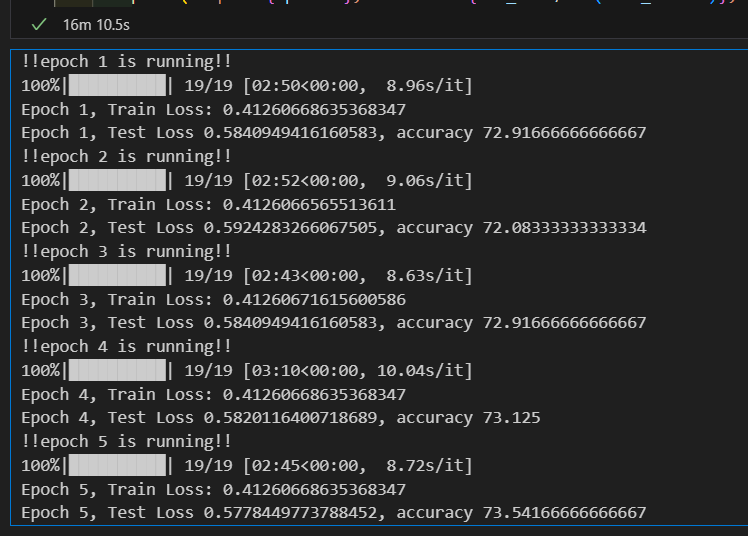